## Mathematical exercises: Pinhole camera
In these exercises we will assume a $modern$ camera with completely square pixels. What are the skew parameters then?

### Exercise 2.1
Reuse the box3d function from last week. Assume that $f$ = 600, $α$ = 1, $β$ = 0, and ${\delta}_x$ = ${\delta}_y$ = 400.
Given a traditional camera, what is the resolution in pixels?
>In a traditional camera, the principal point is exactly in the middle of the sensor. So, for this camera the sensor has 2 × 400 = 800 pixels along each dimension i.e. a resolution of 800 × 800 pixels.

Also assume $R$ = $I$, and $t = \begin{bmatrix}
0 \\ 0.2 \\ 1.5
\end{bmatrix}$
. Use projectpoints from last week, to project the
points.

Are all the points are captured by the image sensor?
Where does the corner $P_1$ = [−0.5,−0.5,−0.5] project to?

>The projection matrix reads $ p = \begin{bmatrix} 600 & 0 & 400 & 600 \\ 0 & 600 & 400 & 720  \\ 0 & 0 & 1 & 1.5 \end{bmatrix} $ Some points have an $y$ value greater than 800, and are not visible in the image, as they are outside the image sensor. $P_1$ projects to $[100,220]^T$

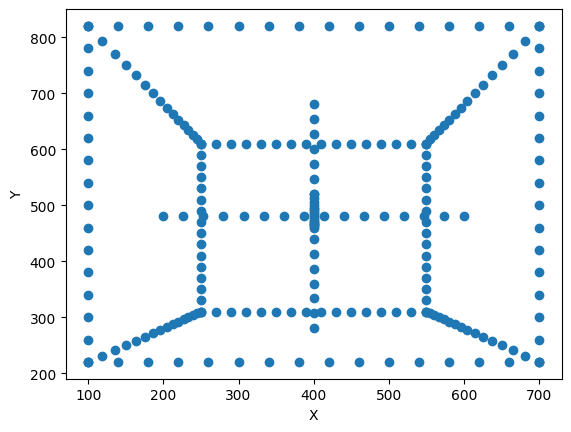

P1 projects to:  [[100.]
 [220.]]


In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def plot_box3d(n=16):
    points = box3d(n)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[0], points[1], points[2])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# converts from homogeneous to inhomogeneous coordinates
def Pi(ph):
    return ph[:-1]/ph[-1]
    
# converts from inhomogeneous to homogeneous coordinates
def PiInv(p):
    ones = np.ones((1, p.shape[1]))
    ph = np.vstack((p, ones))
    return ph

def projectpoints(K, R, t, Q):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    p = K @ PiInv(P)
    return p

def plot_figure(p):
    plt.scatter(p[0], p[1])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


Q = box3d()
K = np.array([[600, 0, 400], [0, 600, 400], [0, 0, 1]])
R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
t = np.array([[0], [0.2], [1.5]])
P1 = np.array([[-0.5,-0.5,-0.5]]).T
p = projectpoints(K, R, t, Q)
p1 = projectpoints(K, R, t, P1)
plot_figure(p[:2])
print("P1 projects to: ", p1[:2])

### Exercise 2.2
Create a new or change your function projectpoints to a version that also takes distCoeffs as
an input. The list distCoeffs should contain the distortion coefficients $[k3, k5, k7, . . . ]$. Make the
function work for at least 3 coefficients.

Test your function with the same setup as in Exercise 2.1 and but assume that the distortion is
$$
\varDelta r(r)=-0.2r^2
$$
What are the distortion coefficients in this case?
> $k_3$ = -0.2, $k_5$ = 0, $k_7$ = 0, ...

Where does the corner $P_1$ project to?
> $[120.4, 232.24]^T$

Are all the points captured by the image sensor?
> All the points are now projecting inside the image, and will thus be visible.

Plot the results and try changing the distortion coefficients. Do they behave as they should?

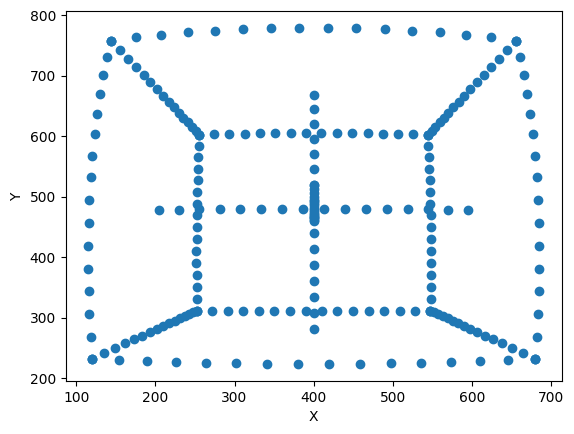

P1 projects to:  [[120.4 ]
 [232.24]]


In [2]:
def p_dist(P, distCoeffs):
    P_power = np.power(P,2)
    r = np.sqrt(P_power[0]+P_power[1]) # sqrt(x^2+y^2) 
    # Δr(r) = k3*r^2+k5*r^4+....
    delta_r = 0
    for i in range(len(distCoeffs)):
        delta_r += distCoeffs[i] * np.power(r, 2*i+2)
    
    P_dist = P * (delta_r +1)
    return P_dist

def projectpoints_dist(K, R, t, Q, distCoeffs):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    # then calculate dist(P)
    P_dist = p_dist(P,distCoeffs)
    q_d = PiInv(P_dist)
    p_d = K @ q_d

    return p_d

# Assume that the distortion is Δ(r)r=-0.2*r^2
# Barrel distortion
distCoeffs = [-0.2]
p = projectpoints_dist(K, R, t, Q, distCoeffs)
p1 = projectpoints_dist(K, R, t, P1, distCoeffs)

plot_figure(p[:2])
print("P1 projects to: ", p1[:2])

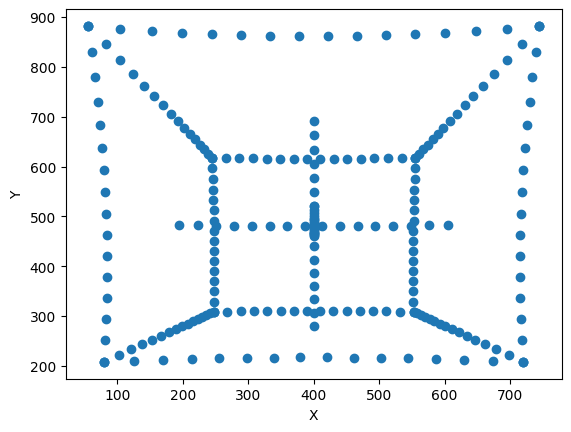

In [3]:
# Pincushion distortion
distCoeffs = [0.2]
p = projectpoints_dist(K, R, t, Q, distCoeffs)
plot_figure(p[:2])

### Exercise 2.3
Download the following image:
https://people.compute.dtu.dk/mohan/02504/gopro_robot.jpg

The image has been captured using a GoPro. Assume that the focal length is 0.455732 times the image width, and a reasonable guess of principal point, $\alpha$, and $\beta$. The distortion coefficients are
$$
k_3 = -0.245031, k_5 = 0.071524, k_7 = -0.00994978
$$
What is K?

In [4]:
import cv2

image = cv2.imread('gopro_robot.jpg')
(h, w, d) = image.shape

focal_length = 0.455732 * w
# The principal point is a reasonable guess, which we can assume as (960, 540) for this calculation.
K = np.array([[focal_length, 0, 960],
              [0, focal_length, 540],
              [0, 0, 1]])
print("The K is: ", K)


The K is:  [[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


### Exercise 2.4
Implement a function undistortImage that takes an image, a camera matrix, and distortion coefficients and returns an undistorted version of the same image. Use the following as an outline of your function

```
x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
q = ...
q_d = ...
p_d = ...
x_d = p_d[0].reshape(x.shape).astype(np.float32)
y_d = p_d[1].reshape(y.shape).astype(np.float32)
assert (p_d[2]==1).all(), 'You did a mistake somewhere'
im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
```
Test the function by undistorting the image from the previous exercise. Are the lines straight now?

$Tip$: Reshape $r$ back to an image and show it to check that it looks like expected.

In [5]:
def undistortImage(im, K, distCoeffs):
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    q = np.linalg.inv(K) @ p
    q_d = p_dist(Pi(q), distCoeffs)
    p_d = K @ PiInv(q_d)
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

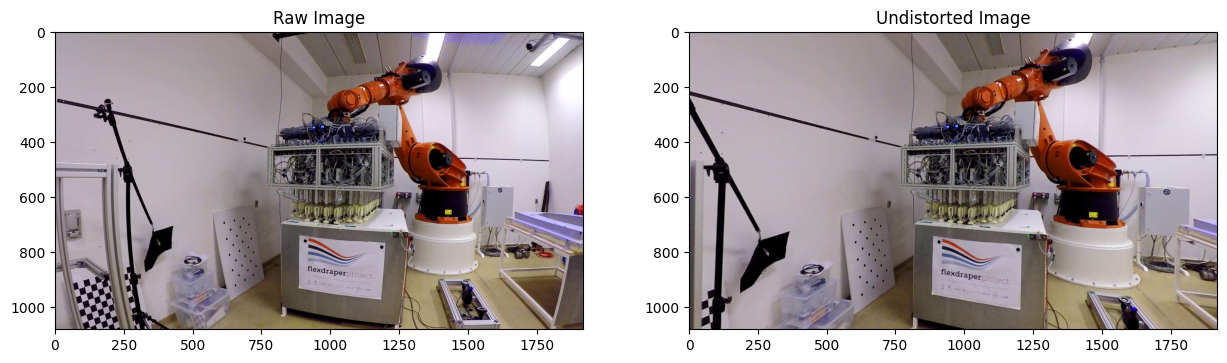

In [6]:
image = cv2.imread('gopro_robot.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
distCoeffs = [-0.245031, 0.071524, -0.00994978]
img = undistortImage(image, K, distCoeffs)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# Plot the images side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
# Plot the raw image
axs[0].imshow(image)
axs[0].set_title('Raw Image')
# Plot the undistorted image
axs[1].imshow(img)
axs[1].set_title('Undistorted Image')
plt.show()

## Homographies
### Exercise 2.5
Consider the following points on a plane
$$
p_{2a} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}, p_{2b} = \begin{bmatrix} 0 \\ 3 \end{bmatrix}, p_{2c} = \begin{bmatrix} 2 \\ 3 \end{bmatrix}, p_{2d} = \begin{bmatrix} 2 \\ 4 \end{bmatrix}.
$$
Using the homography
$$
H = \begin{bmatrix} -2 & 0 & 1 \\ 1 & -2 & 0 \\ 0 & 0 & 3 \end{bmatrix},
$$
map the points using the homography($H_{q_2}$)

---
>To map the points $p_{2a}, p_{2b}, p_{2c}, p_{2d}$ using the homography $H$, we first need to represent them as homogeneous coordinates by appending a 1 as the third coordinate. Thus, we have:
$$
p_{2a} = \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix}, p_{2b} = \begin{bmatrix} 0 \\ 3 \\ 1 \end{bmatrix}, p_{2c} = \begin{bmatrix} 2 \\ 3 \\ 1 \end{bmatrix}, p_{2d} = \begin{bmatrix} 2 \\ 4 \\ 1 \end{bmatrix}.
$$
>To apply the homography $H$ to these points, we simply multiply them with the matrix $H$:
$$
H_{q_2} = H \begin{bmatrix} p_{2a} & p_{2b} & p_{2c} & p_{2d} \end{bmatrix} = \begin{bmatrix} -2 & 0 & 1 \\ 1 & -2 & 0 \\ 0 & 0 & 3 \end{bmatrix} \begin{bmatrix} 1 & 0 & 2 & 2 \\ 1 & 3 & 3 & 4 \\ 1 & 1 & 1 & 1 \end{bmatrix} = \begin{bmatrix} -1 & 1 & -3 & -3 \\ -1 & -6 & -4 & -6 \\ 3 & 3 & 3 & 3 \end{bmatrix}.
$$
>We can extract the mapped points from the matrix $H_{q_2}$ by dividing the first two rows by the third row (since we are dealing with homogeneous coordinates, we can scale the coordinates by a constant factor without changing their value). \
>Therefore, the mapped points are:
$$
p_{q_2a} = \begin{bmatrix} -1/3 \\ -1/3 \end{bmatrix}, p_{q_2b} = \begin{bmatrix} 1/3 \\ -2 \end{bmatrix}, p_{q_2c} = \begin{bmatrix} -1 \\ -4/3 \end{bmatrix}, p_{q_2d} = \begin{bmatrix} -1 \\ -2 \end{bmatrix}.
$$


In [7]:
def homography(H, p):
    ph = PiInv(p)
    qh = H@ph
    return Pi(qh)

p1 = np.array([[1],[1]])
p2 = np.array([[0],[3]])
p3 = np.array([[2],[3]])
p4 = np.array([[2],[4]])
H = np.array([[-2, 0, 1],[1,-2, 0],[0, 0, 3]])

q1 = homography(H,p1)
q2 = homography(H,p2)
q3 = homography(H,p3)
q4 = homography(H,p4)
print('q1 = : ', q1)
print('q2 = : ', q2)
print('q3 = : ', q3)
print('q4 = : ', q4)

q1 = :  [[-0.33333333]
 [-0.33333333]]
q2 = :  [[ 0.33333333]
 [-2.        ]]
q3 = :  [[-1.        ]
 [-1.33333333]]
q4 = :  [[-1.]
 [-2.]]


### Exercise 2.6
Create a function $hest$ that takes two sets of points in 2D, q1 and q2, and returns the estimated homography matrix using the linear algorithm.

Test your function by using the points from the exercise above. Do you get the exact same numbers in your homography, or are they scaled? Explain why this is fine.

In [8]:
def CrossOp(p):
    x, y, z = p.reshape(3)
    ret = np.array([
        [0, - z,  y],
        [z,   0, -x],
        [-y,   x,  0],
    ])
    return ret

def hest(q1,q2):
    q1 = PiInv(q1)
    q2 = PiInv(q2)
    B= np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    
    _,_,vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3))
    H = H.T.round(2)
    
    return H

In [9]:
Q1 = np.hstack((q1,q2,q3,q4))
Q2 = np.hstack((p1,p2,p3,p4))
Hhest = hest(Q1,Q2)
H = np.array([[-2, 0, 1],[1,-2, 0],[0, 0, 3]])
Hhest = Hhest/np.linalg.norm(Hhest,'fro')*np.linalg.norm(H,'fro')
Hhest

array([[-2.,  0.,  1.],
       [ 1., -2., -0.],
       [-0.,  0.,  3.]])

### Exercise 2.7
Create a helper function $normalize2d$. This function finds the transformation $T$ such that $q_{ih}$ = $Tp_{ih}$, has mean [0,0] and standard deviation [1,1] for all $q_i$.

Test it out with some 2D points and make sure the mean and standard deviation are as expected.

In [10]:
def normalized2D(points):
    # Compute the mean and standard deviation of the points
    mean = np.mean(points, axis=1)
    std = np.std(points, axis=1)
    
    # Compute the transformation matrix
    T = np.array([[1/std[0], 0, -mean[0]/std[0]],
                  [0, 1/std[1], -mean[1]/std[1]],
                  [0, 0, 1]])
    
    # Normalize the points using the transformation matrix
    points_hom = np.vstack((points, np.ones(points.shape[1])))
    points_norm_hom = T @ points_hom
    points_norm = points_norm_hom[:2, :]
    
    return T, points_norm   

In [11]:
# Test
points = np.array([[3, 1, 5, 2, 4], [1, 3, 2, 4, 5]])

# Print the original mean and standard deviation of the points
print("Original mean:", np.mean(points, axis=1))
print("Original std:", np.std(points, axis=1))

# Normalize the points
T, points_norm = normalized2D(points)

# Print the normalized mean and standard deviation of the points
print("Normalized mean:", np.mean(points_norm, axis=1))
print("Normalized std:", np.std(points_norm, axis=1))


Original mean: [3. 3.]
Original std: [1.41421356 1.41421356]
Normalized mean: [0. 0.]
Normalized std: [1. 1.]


### Exercise 2.8
Improve your hest function by adding an option (normalize=true/false) to normalize the points with normalize2d before estimating the homography. Apply the T matrices to the estimated H, so the estimated homography still operates on non-normalized points.

In [12]:
def hest(q1, q2, normalize=True):
    if normalize:
        # normalize input points
        T1, q1_norm = normalized2D(q1)
        T2, q2_norm = normalized2D(q2)
    else:
        q1_norm = q1
        q2_norm = q2
    
    q1_norm = PiInv(q1_norm)
    q2_norm = PiInv(q2_norm)
    
    B= np.kron(q2_norm[:,0],CrossOp(q1_norm[:,0]))
    for i in range(1,len(q1_norm[0])):
        B_temp = np.kron(q2_norm[:,i],CrossOp(q1_norm[:,i]))
        B = np.vstack((B,B_temp))
    
    _,_,vh = np.linalg.svd(B.T@B)
    H_norm = np.reshape(vh[-1],(3,3))
    
    if normalize:
        # denormalize H
        H = np.linalg.inv(T2) @ H_norm @ T1
    else:
        H = H_norm
    
    H = H.T.round(2)
    return H


### Exercise 2.9
Generate 100 random 2D points, and a random homography. Map the points using the homography, and use hest to estimate the homography from the points. You can use the following code as a starting point:
```
q2 = np.random.randn(2, 100)
q2h = np.vstack((q2, np.ones(1, 100)))
H_true = np.randon.randn(3,3)
q1h = H_true@q2h
q1 = Pi(q1h)
```

In [15]:
# Generate random points and homography
q2 = np.random.randn(2, 100)
q2h = PiInv(q2)
H_true = np.random.randn(3,3)
q1h = H_true @ q2h
q1 = Pi(q1h)

# Estimate homography with normalization
normalize = True
if normalize:
    T1, q1_norm = normalized2D(q1)
    T2, q2_norm = normalized2D(q2)
    H = hest(q1_norm, q2_norm)
    H = np.linalg.inv(T1) @ H @ T2
else:
    H = hest(q1, q2)

# Compute error
q1h_est = H @ q2h
q1_est = Pi(q1h_est)
err = np.mean(np.linalg.norm(q1 - q1_est, axis=0))

print("True homography:")
print(H_true)
print("Estimated homography:")
print(H)
print("Error:", err)


True homography:
[[-0.43931305 -1.19586672  0.54678517]
 [-0.16071106  0.30579766  0.93028501]
 [-0.5977623  -0.38881208  1.05436007]]
Estimated homography:
[[-0.35295572 -0.97859798  0.43389327]
 [-0.12027097  0.2448344   0.7681813 ]
 [-0.48587937 -0.31371138  0.84769296]]
Error: 0.3139310327833813


### Exercise 2.10
Take a piece of paper and draw at least four ×-marks on it in random locations. Make sure to number them.

Put a small object on top of the paper, and use your phone to take pictures of your paper from two different viewpoints (A and B) Get the x,y coordinates of your ×-marks in image coordinates.\
You can get the coordinates of clicked points with plt.ginput.

Use your annotated points to estimate the homography from image A to image B. Can you click on any point in one image and show where it is in the other image? What happens when you click on the object?

> 1. Choose four or more corresponding points in the two images.
> 2. Compute the homography matrix H that maps the points in one image to the corresponding points in the other image. 
> 3. Use H to transform the second image to align it with the first image.

>If the homography is estimated accurately, it should be able to click on any point in one image and see where it appears in the other image. However, if the object is moved or occluded between the two images, the homography may not align the images correctly, and the correspondence between the points may not be correct.

### Exercise 2.11
Re-create image A, using only pixel intensities from image B. Generate an overlay of the two images. Does the object on top align?
To accomplish this, use the following function:
```
def warpImage(im, H):
imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
return imWarp
```
It takes an image and a homography and returns the image warped with the homography.


>********
>********
>********